In [4]:
import pandas as pd
# import pandas_profiling as ppf
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
from datetime import datetime 
import numpy as np
import os, random, math, time
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

#score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn.model_selection import cross_val_score

#modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# from mlxtend.evaluate import PredefinedHoldoutSplit

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz



# Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
def read_file(filename):
    df = pd.read_csv(f'{filename}', encoding="utf-8") #"cp949"
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def read_file2(filename):
    df = pd.read_excel(f'{filename}', header=None)
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

In [6]:
survey_data = read_file('data/surveydata_md2.csv')

...There are no duplicates
shape: (160, 103)


In [4]:
survey_data.isnull().sum().any()

False

# 1. 추가 전처리

아침식전_복용 ~ 취침전_복용의 경우 약_복용알람으로 합치자.

In [5]:
survey_data['약_복용알람'] = survey_data['아침식전_복용'] + survey_data['아침식후_복용'] + survey_data['점심식전_복용'] + survey_data['점심식후_복용'] + survey_data['저녁식전_복용'] + survey_data['저녁식후_복용'] + survey_data['취침전_복용']

필요한 컬럼 선정

In [6]:
regression_data = survey_data[['sex', '기상', '아침', '점심', '저녁', '취침','종교',
                              '약_복용알람', '환기', '산책', '당뇨', '고지혈',
                              '고혈압', '수급여부', '제공서비스','age',
                               '치매', '우울증', '만성복약', '고립', '거동불편', '소리반응', '인형관심',
                               '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀수',
                               '청결', '식사', '공공방문', 'doll_score',
                              '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
                               '신경과수면제_약', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
                               'human_detection', 'gymnastics', 'brain_timer', 'drug_consume','drug_consume_rt',
                               'slife_before','slife_after']]

In [7]:
regression_data = pd.get_dummies(data = regression_data, drop_first = True)

In [8]:
regression_data.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '환기', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '만성복약', '고립', '거동불편', '소리반응', '인형관심',
       '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀수', '식사', '공공방문',
       'doll_score', '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
       '신경과수면제_약', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
       'human_detection', 'gymnastics', 'brain_timer', 'drug_consume',
       'drug_consume_rt', 'slife_before', 'slife_after', 'sex_여', '종교_무교',
       '종교_불교', '종교_천주교', '수급여부_차상위', '청결_중', '청결_하'],
      dtype='object')

column 추가 제거: 기준은 Feature Selection ipynb에 있음

In [9]:
regression_data.drop(['환기', '만성복약', '소리반응', '인형관심', '모니터링', '배우자'], axis = 1, inplace = True)

약을 먹는데 병에 반영이 안 된 사람들 반영

In [10]:
regression_data.loc[:,'당뇨'][(regression_data['당뇨']==0) & (regression_data['당뇨_약']==1)] = 1
regression_data.loc[:,'우울증'][(regression_data['우울증']==0) & (regression_data['우울증_약']==1)] = 1
regression_data.loc[:,'고지혈'][(regression_data['고지혈']==0) & (regression_data['고지혈증_약']==1)] = 1
regression_data.loc[:,'치매'][(regression_data['치매']==0) & (regression_data['치매_약']==1)] = 1

약 지우기

In [11]:
regression_data.drop(['치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약', '신경과수면제_약'], axis = 1, inplace = True)

In [12]:
regression_data.shape

(160, 41)

In [13]:
regression_data.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '고립', '거동불편', '종교유무', '건강관심', '주택타입',
       '자녀수', '식사', '공공방문', 'doll_score', 'med_count', 'stroke',
       'hand_hold_sum', 'knock', 'human_detection', 'gymnastics',
       'brain_timer', 'drug_consume', 'drug_consume_rt', 'slife_before',
       'slife_after', 'sex_여', '종교_무교', '종교_불교', '종교_천주교', '수급여부_차상위', '청결_중',
       '청결_하'],
      dtype='object')

In [14]:
regression_data[['종교유무','종교_무교', '종교_불교', '종교_천주교']][regression_data['종교유무']==regression_data['종교_무교']]

,종교유무,종교_무교,종교_불교,종교_천주교
0,0,0,1,0
1,1,1,0,0
2,1,1,0,0
4,0,0,1,0
5,0,0,0,0
...,...,...,...,...
151,0,0,0,0
152,1,1,0,0
153,0,0,0,0
154,0,0,0,0


- 일단 다르든 같든 160개가 안되는건 문제가 있다 

In [15]:
regression_data.drop(['종교유무','종교_불교', '종교_천주교'], axis = 1, inplace = True)

## Train/Test Split

In [16]:
from sklearn.model_selection import train_test_split

## 우울증은 점수 높은게 안좋은거고, change는 +가 좋은 것으로 바꿔준 상태

In [17]:
survey_data[['doll_id', 'psy_before', 'psy_after',
       'psy_before_cat', 'psy_after_cat', 'psy_change']].head(5)

,doll_id,psy_before,psy_after,psy_before_cat,psy_after_cat,psy_change
0,126401,9,12,위험낮음,고위험군,-3
1,126497,6,6,위험낮음,위험낮음,0
2,126498,3,3,위험낮음,위험낮음,0
3,126500,8,11,위험낮음,고위험군,-3
4,126501,9,4,위험낮음,위험낮음,5


In [18]:
#긍정변화 여부
Y3 = survey_data['psy_change']> 0 

Y3.replace([True, False], [1,0], inplace = True)

In [19]:
X = regression_data

In [20]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 123, stratify = Y3)

### *Numeric Data Scaling

In [21]:
X_train.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '고립', '거동불편', '건강관심', '주택타입', '자녀수', '식사',
       '공공방문', 'doll_score', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
       'human_detection', 'gymnastics', 'brain_timer', 'drug_consume',
       'drug_consume_rt', 'slife_before', 'slife_after', 'sex_여', '종교_무교',
       '수급여부_차상위', '청결_중', '청결_하'],
      dtype='object')

기상, 아침, 점심, 저녁, 취침, 약 복용알람, age, 자녀수, doll_score, med_count, stroke, hand_hold_sum, knock, human_detection, gymnastics, brain_timer, drug_consume, slife_before, slife_after

In [22]:
numeric_columns = ['기상', '아침', '점심', '저녁', '취침', '약_복용알람', 'age', '자녀수', 'doll_score', 'med_count', 'stroke',
                   'hand_hold_sum', 'knock', 'human_detection', 'gymnastics', 'brain_timer', 'drug_consume',
                   'slife_before', 'slife_after']

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
min_max_scaler = MinMaxScaler()

#train, test scaling
X_train[numeric_columns] = min_max_scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = min_max_scaler.transform(X_test[numeric_columns])

### Y data split

In [25]:
#원점수
Y1 = survey_data.loc[:,'psy_after']
Y1_train = survey_data.loc[list(X_train.index.values), 'psy_after']
Y1_test = survey_data.loc[list(X_test.index.values), 'psy_after']

#변화점수
Y2 = survey_data.loc[:, 'psy_change']
Y2_train = survey_data.loc[list(X_train.index.values), 'psy_change']
Y2_test = survey_data.loc[list(X_test.index.values), 'psy_change']

#긍정변화여부
Y3_train = Y3[list(X_train.index.values)]
Y3_test = Y3[list(X_test.index.values)]

## High Correlation 제거

In [26]:
for i, c1 in enumerate (X_train.columns):
    for j, c2 in enumerate (X_train.columns):
        if (i> j )& (abs(X_train.corr().iloc[i,j])>=0.7):
            print(c1," + ",c2, ' : ', np.round(X_train.corr().iloc[i,j],4))

brain_timer  +  hand_hold_sum  :  0.8127
brain_timer  +  gymnastics  :  0.8742


In [27]:
X_train.drop(['brain_timer'], axis = 1, inplace = True)

In [28]:
X = X[X_train.columns]
X_test = X_test[X_train.columns]

In [29]:
for i, c1 in enumerate (X_train.columns):
    for j, c2 in enumerate (X_train.columns):
        if (i> j )& (abs(X_train.corr().iloc[i,j])>=0.7):
            print(c1," + ",c2, ' : ', np.round(X_train.corr().iloc[i,j],4))

# 1. 우울증 원점수

## 1-1. Linear Regression

In [30]:
import statsmodels.api as sm
X_Sm= sm.add_constant(X_train)
ls=sm.OLS(Y1_train,X_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:              psy_after   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     2.399
Date:                Fri, 19 Nov 2021   Prob (F-statistic):           0.000408
Time:                        22:33:07   Log-Likelihood:                -254.12
No. Observations:                 128   AIC:                             584.2
Df Residuals:                      90   BIC:                             692.6
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.4466      2.609     

In [31]:
X_Sm = sm.add_constant(X_train)
Y1_pred = ls.predict(X_Sm)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 1.7618591656234952


## 우울증 점수 범위가 0~15 라는 점을 생각하면, 그렇게 잘 맞추지는 못하는듯

In [32]:
X_Sm = sm.add_constant(X_test)
Y1_pred = ls.predict(X_Sm)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 3.474860412843347


## 1-2. Lasso CV

In [33]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [34]:
las = LassoCV()
las.fit(X_train, Y1_train)
print("Best alpha using built-in LassoCV: %f" % las.alpha_)
print("Best score using built-in LassoCV: %f" %las.score(X_train,Y1_train))
coef = pd.Series(las.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.115310
Best score using built-in LassoCV: 0.196908


In [35]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 31 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

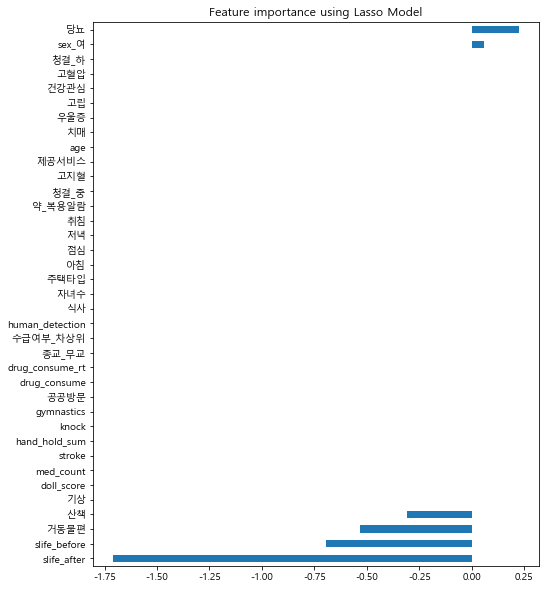

In [36]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [37]:
Y1_pred = las.predict(X_train)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 2.2252370732773605


In [38]:
Y1_pred = las.predict(X_test)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 2.1924658677249003


## 1-3. Ridge CV

In [39]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

In [40]:
rid = RidgeCV()
rid.fit(X_train, Y1_train)
print("Best alpha using built-in RidgeCV: %f" % rid.alpha_)
print("Best score using built-in RidgeCV: %f" % rid.score(X_train,Y1_train))
coef = pd.Series(rid.coef_, index = X_train.columns)

Best alpha using built-in RidgeCV: 10.000000
Best score using built-in RidgeCV: 0.369167


Text(0.5, 1.0, 'Feature importance using Ridge Model')

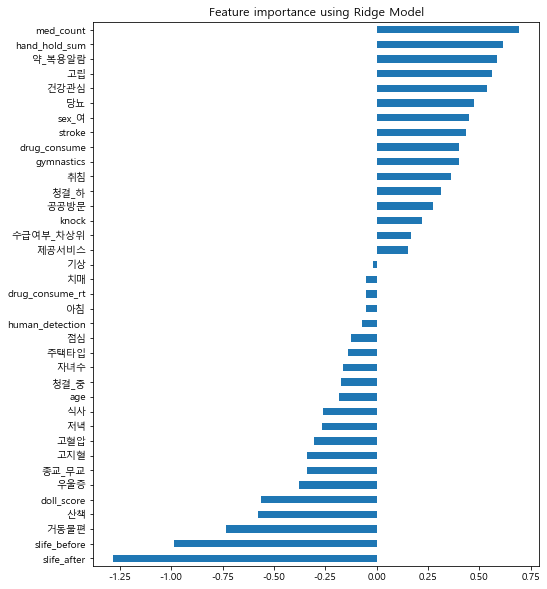

In [41]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")

In [42]:
Y1_pred = rid.predict(X_train)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 1.9722003858903117


In [43]:
Y1_pred = rid.predict(X_test)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 2.718651099044792


## 1-4. Linear Mixed Model

In [44]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [45]:
X_train.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '고립', '거동불편', '건강관심', '주택타입', '자녀수', '식사',
       '공공방문', 'doll_score', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
       'human_detection', 'gymnastics', 'drug_consume', 'drug_consume_rt',
       'slife_before', 'slife_after', 'sex_여', '종교_무교', '수급여부_차상위', '청결_중',
       '청결_하'],
      dtype='object')

In [46]:
#doll_id 기준 group
X2 = pd.concat([X_train, survey_data['doll_id'][survey_data.index.isin(X_train.index)]], axis = 1)
X2 = pd.concat([X2, Y1_train], axis = 1)

In [47]:
#기관 기준 group
X3 = pd.concat([X_train, survey_data['기관2'][survey_data.index.isin(X_train.index)]], axis = 1)
X3 = pd.concat([X3, Y1_train], axis = 1)

In [48]:
#psy_before_cat 기준 group
X4 = pd.concat([X_train, survey_data['slife_before_cat'][survey_data.index.isin(X_train.index)]], axis = 1)
X4 = pd.concat([X4, Y1_train], axis =1)

### 1) doll_id 기준 group

In [49]:
doll_formula = 'psy_after ~ '
for i,j in enumerate(X2.drop(['doll_id','psy_after'], axis = 1).columns):
    if i==0:
        doll_formula += j
    else:
        doll_formula += '+' + j

In [50]:
doll_formula

'psy_after ~ 기상+아침+점심+저녁+취침+약_복용알람+산책+당뇨+고지혈+고혈압+제공서비스+age+치매+우울증+고립+거동불편+건강관심+주택타입+자녀수+식사+공공방문+doll_score+med_count+stroke+hand_hold_sum+knock+human_detection+gymnastics+drug_consume+drug_consume_rt+slife_before+slife_after+sex_여+종교_무교+수급여부_차상위+청결_중+청결_하'

In [51]:
doll_md = smf.mixedlm(formula = doll_formula, data = X2, groups = X2['doll_id'])

In [52]:
doll_mdf = doll_md.fit()
print(doll_mdf.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  psy_after
No. Observations:  128      Method:              REML     
No. Groups:        128      Scale:               2.2074   
Min. group size:   1        Log-Likelihood:      -234.6316
Max. group size:   1        Converged:           Yes      
Mean group size:   1.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       12.447    2.609  4.771 0.000  7.334 17.559
기상              -2.463    2.242 -1.098 0.272 -6.857  1.932
아침               1.956    2.265  0.863 0.388 -2.484  6.396
점심              -0.738    1.707 -0.432 0.666 -4.084  2.608
저녁              -1.794    1.530 -1.173 0.241 -4.792  1.205
취침               0.481    0.605  0.794 0.427 -0.705  1.667
약_복용알람           1.934    1.445  1.339 0.181 -0.898  4.766
산책      

C:\Users\dbdms\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [53]:
doll_pred = doll_mdf.predict(X2.iloc[:,:-2])
doll_pred[doll_pred>15]= 15
doll_pred[doll_pred<0]= 0
rms = sqrt(mean_squared_error(Y1_train, doll_pred))
rms

2.8776847541581962

오히려 별로군

### 2) 기관 기준 group

In [54]:
기관_formula = 'psy_after ~ '
for i,j in enumerate(X3.drop(['기관2','psy_after'], axis = 1).columns):
    if i==0:
        기관_formula += j
    else:
        기관_formula += '+' + j

In [55]:
기관_formula

'psy_after ~ 기상+아침+점심+저녁+취침+약_복용알람+산책+당뇨+고지혈+고혈압+제공서비스+age+치매+우울증+고립+거동불편+건강관심+주택타입+자녀수+식사+공공방문+doll_score+med_count+stroke+hand_hold_sum+knock+human_detection+gymnastics+drug_consume+drug_consume_rt+slife_before+slife_after+sex_여+종교_무교+수급여부_차상위+청결_중+청결_하'

In [56]:
기관_md = smf.mixedlm(formula = 기관_formula, data = X3, groups = X3['기관2'])
기관_mdf = 기관_md.fit()
print(기관_mdf.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  psy_after
No. Observations:  128      Method:              REML     
No. Groups:        7        Scale:               4.4148   
Min. group size:   2        Log-Likelihood:      -234.6316
Max. group size:   42       Converged:           Yes      
Mean group size:   18.3                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       12.447    2.637  4.720 0.000  7.278 17.615
기상              -2.463    2.282 -1.079 0.281 -6.935  2.010
아침               1.956    2.521  0.776 0.438 -2.985  6.896
점심              -0.738    1.749 -0.422 0.673 -4.166  2.690
저녁              -1.794    1.621 -1.107 0.268 -4.970  1.383
취침               0.481    0.607  0.792 0.428 -0.709  1.670
약_복용알람           1.934    1.467  1.319 0.187 -0.940  4.809
산책      

C:\Users\dbdms\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [57]:
기관_pred = 기관_mdf.predict(X3.iloc[:,:-2])
기관_pred[기관_pred>15]= 15
기관_pred[기관_pred<0]= 0
rms = sqrt(mean_squared_error(Y1_train, 기관_pred))
rms

2.877684753061865

### 3) slife_before_cat 기준 group

In [58]:
psy_formula = 'psy_after ~ '
for i,j in enumerate(X4.drop(['slife_before_cat','psy_after'], axis = 1).columns):
    if i==0:
        psy_formula += j
    else:
        psy_formula += '+' + j

In [59]:
psy_formula

'psy_after ~ 기상+아침+점심+저녁+취침+약_복용알람+산책+당뇨+고지혈+고혈압+제공서비스+age+치매+우울증+고립+거동불편+건강관심+주택타입+자녀수+식사+공공방문+doll_score+med_count+stroke+hand_hold_sum+knock+human_detection+gymnastics+drug_consume+drug_consume_rt+slife_before+slife_after+sex_여+종교_무교+수급여부_차상위+청결_중+청결_하'

In [60]:
psy_md = smf.mixedlm(formula = psy_formula, data = X4, re_formula = '~slife_before', groups = X4['slife_before_cat'])
psy_mdf = psy_md.fit()
print(psy_mdf.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     psy_after
No. Observations:      128         Method:                 REML     
No. Groups:            2           Scale:                  4.3309   
Min. group size:       46          Log-Likelihood:         -234.2725
Max. group size:       82          Converged:              Yes      
Mean group size:       64.0                                         
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                12.726   21.842  0.583 0.560 -30.084 55.535
기상                       -2.710   12.749 -0.213 0.832 -27.698 22.279
아침                        2.123   19.756  0.107 0.914 -36.598 40.843
점심                       -0.849    3.372 -0.252 0.801  -7.458  5.760
저녁                       -2.042   10.718 -0.191 0.

C:\Users\dbdms\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [61]:
psy_pred = psy_mdf.predict(X4.iloc[:,:-2])
psy_pred[psy_pred>15]= 15
psy_pred[psy_pred<0]= 0
rms = sqrt(mean_squared_error(Y1_train, psy_pred))
rms

3.0085774233417637

## 1-5. SFS (Linear Regression)

### Forward

In [62]:
ols = LinearRegression()
sfs_forward = SFS(estimator=ols, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=True, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_forward.fit(X_train, Y1_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [63]:
selected_variables = list(sfs_forward.k_feature_names_)
selected_variables

['약_복용알람',
 '고립',
 '거동불편',
 '건강관심',
 'med_count',
 'stroke',
 'hand_hold_sum',
 'slife_before',
 'slife_after',
 '종교_무교']

In [64]:
print('best average cv_score:',sfs_forward.k_score_)

best average cv_score: -2.056721862705718


In [65]:
ols.fit(X_train[selected_variables], Y1_train)
Y1_pred = ols.predict(X_train[selected_variables])
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 1.9669916330146568


In [66]:
Y1_pred = ols.predict(X_test[selected_variables])
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 3.3046659220844163


### Backward

In [67]:
# ols = LinearRegression()
# sfs_backward = SFS(estimator=ols, 
#            k_features=(5, 15),
#            forward=False, 
#            floating=False, 
#            scoring='neg_root_mean_squared_error', cv = 5)

# sfs_backward.fit(X_train, Y1_train)

In [68]:
# selected_variables = list(sfs_backward.k_feature_names_)
# selected_variables

In [69]:
# print('best average cv_score:',sfs_backward.k_score_)

In [70]:
# ols.fit(X_train[selected_variables], Y1_train)
# Y1_pred = ols.predict(X_train[selected_variables])
# rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
# print('train_rmse:',rmse)

In [71]:
# Y1_pred = ols.predict(X_test[selected_variables])
# rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
# print('test_rmse:',rmse)

## 1-6. Decision Tree

In [72]:
randomseed = 1234

In [73]:
dtree = DecisionTreeRegressor(random_state=randomseed, min_samples_leaf=4)
dtree.fit(X_train, Y1_train)

DecisionTreeRegressor(min_samples_leaf=4, random_state=1234)

In [74]:
Y1_pred = dtree.predict(X_train)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 1.3063774430881465


In [75]:
Y1_pred = dtree.predict(X_test)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 2.8345249032517237


## 1-7. Random Forest

In [76]:
randomseed = 1234

In [77]:
rforest = RandomForestRegressor(random_state = randomseed, min_samples_leaf=5)
rforest.fit(X_train, Y1_train)

RandomForestRegressor(min_samples_leaf=5, random_state=1234)

In [78]:
Y1_pred = rforest.predict(X_train)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 1.5266842551996254


In [79]:
Y1_pred = rforest.predict(X_test)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 2.097439125339657


## 저는 괜찮다고 생각합니다

## 1-8. XGBoost

In [80]:
randomseed = 1234

In [81]:
xgb = XGBRegressor(random_state = randomseed, max_depth = 5)
xgb.fit(X_train, Y1_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [82]:
Y1_pred = xgb.predict(X_train)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 0.0007474329682201292


In [83]:
Y1_pred = xgb.predict(X_test)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 2.3053894170870124


## 1-9. LGBM

In [84]:
randomseed = 1234

In [85]:
lgbm = LGBMRegressor(random_state = randomseed, max_depth = 5)
lgbm.fit(X_train, Y1_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


LGBMRegressor(max_depth=5, random_state=1234)

In [86]:
Y1_pred = lgbm.predict(X_train)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 0.9763148080773799


In [87]:
Y1_pred = lgbm.predict(X_test)
Y1_pred[Y1_pred>15]= 15
Y1_pred[Y1_pred<0]= 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 2.3474430093064993


# 2. 우울증 Change(점수)

## 2-1. Linear Regression

<AxesSubplot:xlabel='psy_change', ylabel='Count'>

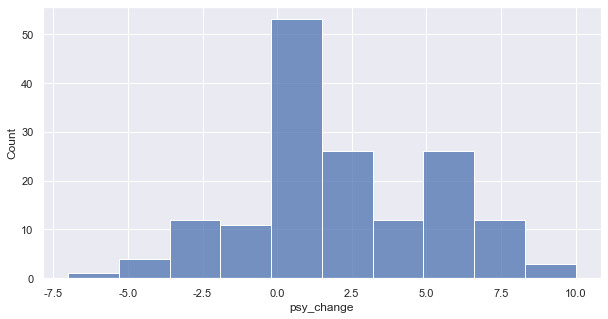

In [88]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.histplot(Y2)

In [89]:
import statsmodels.api as sm
X_Sm= sm.add_constant(X_train)
ls=sm.OLS(Y2_train,X_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:             psy_change   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.9779
Date:                Fri, 19 Nov 2021   Prob (F-statistic):              0.517
Time:                        22:33:22   Log-Likelihood:                -303.76
No. Observations:                 128   AIC:                             683.5
Df Residuals:                      90   BIC:                             791.9
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.6963      3.845     

In [90]:
X_Sm = sm.add_constant(X_train)
Y2_pred = ls.predict(X_Sm)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 2.596616966839136


In [91]:
X_Sm = sm.add_constant(X_test)
Y2_pred = ls.predict(X_Sm)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 7.681681962883874


## 별로야

## 2-2. Lasso CV

In [92]:
las = LassoCV()
las.fit(X_train, Y2_train)
print("Best alpha using built-in LassoCV: %f" % las.alpha_)
print("Best score using built-in LassoCV: %f" %las.score(X_train,Y2_train))
coef = pd.Series(las.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.179688
Best score using built-in LassoCV: 0.000000


In [93]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 0 variables and eliminated the other 37 variables


## 2-3. Ridge CV

In [94]:
rid = RidgeCV()
rid.fit(X_train, Y2_train)
print("Best alpha using built-in RidgeCV: %f" % rid.alpha_)
print("Best score using built-in RidgeCV: %f" % rid.score(X_train,Y2_train))
coef = pd.Series(las.coef_, index = X_train.columns)

Best alpha using built-in RidgeCV: 10.000000
Best score using built-in RidgeCV: 0.190993


In [95]:
Y2_pred = rid.predict(X_train)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.765437944775934


In [96]:
Y2_pred = rid.predict(X_test)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 4.003732268552448


## 2-4. SFS (Linear Regression)

### Forward

In [97]:
ols = LinearRegression()
sfs_forward = SFS(estimator=LinearRegression(), 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=True, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_forward.fit(X_train, Y2_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [98]:
selected_variables = list(sfs_forward.k_feature_names_)
selected_variables

['기상',
 '고지혈',
 '제공서비스',
 '고립',
 'doll_score',
 'med_count',
 'stroke',
 'hand_hold_sum',
 'slife_before']

In [99]:
print('best average cv_score:',sfs_forward.k_score_)

best average cv_score: -2.949055524151934


In [100]:
ols.fit(X_train[selected_variables], Y2_train)
Y2_pred = ols.predict(X_train[selected_variables])
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.807974002025968


In [101]:
Y2_pred = ols.predict(X_test[selected_variables])
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:',rmse)

test_rmse: 7.428582082333232


### Backward

In [102]:
# ols = LinearRegression()
# sfs_backward = SFS(estimator=ols, 
#            k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
#            forward=False, 
#            floating=False, 
#            scoring='neg_root_mean_squared_error', cv = 5)

# sfs_backward.fit(X_train, Y2_train)

In [103]:
# selected_variables = list(sfs_backward.k_feature_names_)
# selected_variables

In [104]:
# print('best average cv_score:',sfs_backward.k_score_)

In [105]:
# ols.fit(X_train[selected_variables], Y2_train)
# Y2_pred = ols.predict(X_train[selected_variables])
# rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
# print('train_rmse:',rmse)

In [106]:
# Y2_pred = ols.predict(X_test[selected_variables])
# rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
# print('test_rmse:',rmse)

## change는 노답인듯

## 2-5. Decision Tree

In [107]:
randomseed = 1234

In [108]:
dtree = DecisionTreeRegressor(random_state=randomseed, min_samples_leaf=5)
dtree.fit(X_train, Y2_train)

DecisionTreeRegressor(min_samples_leaf=5, random_state=1234)

In [109]:
Y2_pred = dtree.predict(X_train)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 1.8785317267516932


In [110]:
Y2_pred = dtree.predict(X_test)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 4.449413676089529


## 2-6. Random Forest

In [111]:
randomseed = 1234

In [112]:
rforest = RandomForestRegressor(random_state = randomseed, min_samples_leaf=5)
rforest.fit(X_train, Y2_train)

RandomForestRegressor(min_samples_leaf=5, random_state=1234)

In [113]:
Y2_pred = rforest.predict(X_train)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 2.0255485644293554


In [114]:
Y2_pred = rforest.predict(X_test)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 3.4813840756796637


## 2-7. XGBoost

In [115]:
randomseed = 1234

In [116]:
xgb = XGBRegressor(random_state = randomseed, max_depth = 5)
xgb.fit(X_train, Y2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [117]:
Y2_pred = xgb.predict(X_train)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 0.0007217289728154757


In [118]:
Y2_pred = xgb.predict(X_test)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 3.291060966129849


## 2-8. LightGBM

In [119]:
randomseed = 1234

In [120]:
lgbm = LGBMRegressor(random_state = randomseed, max_depth = 5)
lgbm.fit(X_train, Y2_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


LGBMRegressor(max_depth=5, random_state=1234)

In [121]:
Y2_pred = lgbm.predict(X_train)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 1.456008620205475


In [122]:
Y2_pred = lgbm.predict(X_test)
Y2_pred[Y2_pred>15]= 15
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 3.2970310489714487


# 3. 긍정변화여부

## 3-1. Logistic Regression

In [123]:
print(Y3_train.value_counts(), '\n\n', Y3_test.value_counts())

1    82
0    46
Name: psy_change, dtype: int64 

 1    21
0    11
Name: psy_change, dtype: int64


proba 조정할 시 0.8 정도로

In [124]:
X_Sm= sm.add_constant(X_train)
logit=sm.Logit(Y3_train,X_Sm).fit()
print(ls.summary())

Optimization terminated successfully.
         Current function value: 0.468992
         Iterations 8
                            OLS Regression Results                            
Dep. Variable:             psy_change   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.9779
Date:                Fri, 19 Nov 2021   Prob (F-statistic):              0.517
Time:                        22:33:31   Log-Likelihood:                -303.76
No. Observations:                 128   AIC:                             683.5
Df Residuals:                      90   BIC:                             791.9
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------

마이너스?

In [125]:
logit = LogisticRegression()
logit.fit(X_train, Y3_train)
Y3_pred = logit.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:',accu)

train_accuracy: 0.7265625


In [126]:
Y3_pred = logit.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.59375


In [127]:
pd.crosstab(Y3_test, Y3_pred)

col_0,0,1
psy_change,,
0,5,6
1,7,14


## 3-2. SFS

### Forward

In [128]:
logit = LogisticRegression()
sfs_forward = SFS(estimator=logit, 
           k_features=(5, 15),
           forward=True, 
           floating=False, 
           scoring='accuracy', cv = 5)

sfs_forward.fit(X_train, Y3_train)

SequentialFeatureSelector(estimator=LogisticRegression(), k_features=(5, 15),
                          scoring='accuracy')

In [129]:
selected_variables = list(sfs_forward.k_feature_names_)
selected_variables

['아침',
 '점심',
 '취침',
 '약_복용알람',
 '건강관심',
 'doll_score',
 'med_count',
 'drug_consume_rt',
 '청결_하']

In [130]:
print('best average cv_score:',sfs_forward.k_score_)

best average cv_score: 0.6953846153846155


In [131]:
logit = LogisticRegression()
logit.fit(X_train[selected_variables], Y3_train)
Y3_pred = logit.predict(X_train[selected_variables])
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:',accu)

train_accuracy: 0.6640625


In [132]:
Y3_pred = logit.predict(X_test[selected_variables])
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:',accu)

test_accuracy: 0.6875


In [133]:
pd.crosstab(Y3_test, Y3_pred)

col_0,0,1
psy_change,,
0,1,10
1,0,21


In [134]:
logit = LogisticRegression()
logit.fit(X_train[selected_variables], Y3_train)

Y3_pred_df = pd.DataFrame(logit.predict_proba(X_train[selected_variables]))
Y3_pred_df['yhat'] = 0
Y3_pred_df.loc[Y3_pred_df[1]>=0.6, 'yhat']=1

accu = accuracy_score(Y3_train, Y3_pred_df['yhat'])
print('train_accuracy:',accu)

train_accuracy: 0.625


In [135]:
Y3_pred_df = pd.DataFrame(logit.predict_proba(X_test[selected_variables]))
Y3_pred_df['yhat'] = 0
Y3_pred_df.loc[Y3_pred_df[1]>=0.6, 'yhat']=1

accu = accuracy_score(Y3_test, Y3_pred_df['yhat'])
print('test_accuracy:',accu)

test_accuracy: 0.65625


In [136]:
pd.crosstab(Y3_test.reset_index(drop=True), Y3_pred_df['yhat'])

yhat,1
psy_change,
0,11
1,21


### Backward

In [137]:
# logit = LogisticRegression()
# sfs_backward = SFS(estimator=logit, 
#            k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
#            forward=False, 
#            floating=False, 
#            scoring='accuracy', cv = 5)

# sfs_backward.fit(X_train, Y3_train)

In [138]:
# selected_variables = list(sfs_backward.k_feature_names_)
# selected_variables

In [139]:
# print('best average cv_score:',sfs_backward.k_score_)

In [140]:
# logit = LogisticRegression()
# logit.fit(X_train[selected_variables], Y3_train)
# Y3_pred = logit.predict(X_train[selected_variables])
# accu = accuracy_score(Y3_train, Y3_pred)
# print('train_accuracy:', accu)

In [141]:
# Y3_pred = logit.predict(X_test[selected_variables])
# accu = accuracy_score(Y3_test, Y3_pred)
# print('test_accuracy:', accu)

## 3-3. Decision Tree

In [169]:
randomseed = 1234

In [176]:
randomseed = 2021

In [195]:
dtree = DecisionTreeClassifier(random_state=randomseed, min_samples_leaf=8)
dtree.fit(X_train, Y3_train)

DecisionTreeClassifier(min_samples_leaf=8, random_state=2021)

In [196]:
Y3_pred = dtree.predict(X_train)

accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.765625


In [197]:
Y3_pred = dtree.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.53125


In [198]:
pd.crosstab(Y3_test, Y3_pred)

col_0,0,1
psy_change,,
0,6,5
1,10,11


In [199]:
Y3_pred_df = pd.DataFrame(dtree.predict_proba(X_train))
Y3_pred_df['yhat'] = 0
Y3_pred_df.loc[Y3_pred_df[1]>=0.6, 'yhat']=1

accu = accuracy_score(Y3_train, Y3_pred_df['yhat'])
print('train_accuracy:',accu)


Y3_pred_df = pd.DataFrame(dtree.predict_proba(X_test))
Y3_pred_df['yhat'] = 0
Y3_pred_df.loc[Y3_pred_df[1]>=0.6, 'yhat']=1

accu = accuracy_score(Y3_test, Y3_pred_df['yhat'])
print('test_accuracy:',accu)

train_accuracy: 0.7578125
test_accuracy: 0.4375


## 3-4. RandomForest

In [228]:
rforest = RandomForestClassifier(random_state=123, min_samples_leaf=4, criterion = 'gini')
rforest.fit(X_train, Y3_train)

RandomForestClassifier(min_samples_leaf=4, random_state=123)

In [229]:
Y3_pred = rforest.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

Y3_pred = rforest.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

train_accuracy: 0.9140625
test_accuracy: 0.71875


In [258]:
rforest = RandomForestClassifier(random_state=11, min_samples_leaf=4, criterion = 'gini')
rforest.fit(X_train, Y3_train)

Y3_pred = rforest.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

Y3_pred = rforest.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

train_accuracy: 0.890625
test_accuracy: 0.75


In [259]:
pd.crosstab(Y3_test, Y3_pred)

col_0,0,1
psy_change,,
0,4,7
1,1,20


## 마법의 지니와 시드

## cut off 바꾸면 더 안좋아지는 경우가 많네용

In [260]:
Y3_pred_df = pd.DataFrame(rforest.predict_proba(X_train))
Y3_pred_df['yhat'] = 0
Y3_pred_df.loc[Y3_pred_df[1]>=0.6, 'yhat']=1

accu = accuracy_score(Y3_train.reset_index(drop=True), Y3_pred_df['yhat'])
print('train_accuracy:',accu)


Y3_pred_df = pd.DataFrame(rforest.predict_proba(X_test))
Y3_pred_df['yhat'] = 0
Y3_pred_df.loc[Y3_pred_df[1]>=0.6, 'yhat']=1

accu = accuracy_score(Y3_test, Y3_pred_df['yhat'])
print('test_accuracy:',accu)

train_accuracy: 0.96875
test_accuracy: 0.625


## 3-5. XGBoost

In [270]:
xgb = XGBClassifier(random_state=115, learning_rate = 0.01, max_depth = 5, gamma=1, base_score = 0.7)
xgb.fit(X_train, Y3_train)

XGBClassifier(base_score=0.7, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=115,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [271]:
Y3_pred = xgb.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.875


In [272]:
Y3_pred = xgb.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.59375


## 3-6. LGBM

In [299]:
lgbm = LGBMClassifier(random_state=5, learning_rate = 0.01, max_depth = 4, min_child_samples=4, num_leaves = 9)
lgbm.fit(X_train, Y3_train)

LGBMClassifier(learning_rate=0.01, max_depth=4, min_child_samples=4,
               num_leaves=9, random_state=5)

In [300]:
Y3_pred = lgbm.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.875


In [301]:
Y3_pred = lgbm.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.65625


In [302]:
pd.crosstab(Y3_test, Y3_pred)

col_0,0,1
psy_change,,
0,2,9
1,2,19
